In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime

import geopandas as gpd

import seaborn as sns

from sklearn.cluster import KMeans

In [36]:
# Reading datasets from two different time periods

# https://data.lacity.org/Public-Safety/Crime-Data-from-2010-to-2019/63jg-8b9z
past_df = pd.read_csv("Crime_Data_from_2010_to_2019.csv", dtype = {"TIME OCC": str})
# https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8
present_df = pd.read_csv("Crime_Data_from_2020_to_Present.csv", dtype = {"TIME OCC": str})

LAPD_df = pd.read_csv("LAPD_Police_Stations.csv")

# past dataset has column name typo
past_df = past_df.rename(columns={"AREA ": "AREA"})

# Both datasets use the same columns 
df = pd.concat([past_df, present_df])

In [37]:
df = df.drop(columns=[
    "Crm Cd", "Crm Cd 1", "Crm Cd 2", "Crm Cd 3", 
    "Crm Cd 4", "Premis Cd", "Weapon Used Cd", 
    "Mocodes", "Part 1-2", "Status", "Date Rptd"
    ])

# Changed code to be readable description
df["Vict Descent"] = df["Vict Descent"].replace({
                            "A": "Other Asian", 
                            "B": "Black", 
                            "C": "Chinese", 
                            "D": "Cambodian", 
                            "F": "Filipino", 
                            "G": "Guamanian", 
                            "H": "Hispanic/Latin/Mexican", 
                            "I": "American Indian/Alaskan Native", 
                            "J": "Japanese", 
                            "K": "Korean", 
                            "L": "Laotian", 
                            "O": "Other", 
                            "P": "Pacific Islander", 
                            "S": "Samoan", 
                            "U": "Hawaiian", 
                            "V": "Vietnamese", 
                            "W": "White", 
                            "X": "Unknown", 
                            "Z": "Asian Indian",
                        })

In [38]:
LAPD_df = LAPD_df.rename(columns={
    "X": "Longitude", 
    "Y": "Latitude"
    })

# Top 5 Crimes Per Area (EDA Inclusion)

In [51]:
df_plot = df.loc[(df['LAT'] >= 33.7) & (df['LAT'] <= 34.37) & (df['LON'] >= -118.7) & (df['LON'] <= -118.15)]
top_5 = pd.Series(df_plot['Crm Cd Desc'].value_counts()[:5].index)
top_5_list = np.array(df_plot['Crm Cd Desc'].value_counts()[:5].index)
top_5

0              BATTERY - SIMPLE ASSAULT
1                      VEHICLE - STOLEN
2                 BURGLARY FROM VEHICLE
3                              BURGLARY
4    THEFT PLAIN - PETTY ($950 & UNDER)
dtype: object

In [52]:
top_5_plot = df_plot[df_plot['Crm Cd Desc'].isin(top_5_list)]

In [53]:
def label_change(string):
    if string == top_5[0]:
        return 1
    elif string == top_5[1]:
        return 2
    elif string == top_5[2]:
        return 3
    elif string == top_5[3]:
        return 4
    else:
        return 5

In [54]:
top_5_plot['Num Crime'] = top_5_plot['Crm Cd Desc'].apply(label_change)

<ipython-input-54-4106155d0b07>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_plot['Num Crime'] = top_5_plot['Crm Cd Desc'].apply(label_change)


<AxesSubplot:xlabel='LON', ylabel='LAT'>

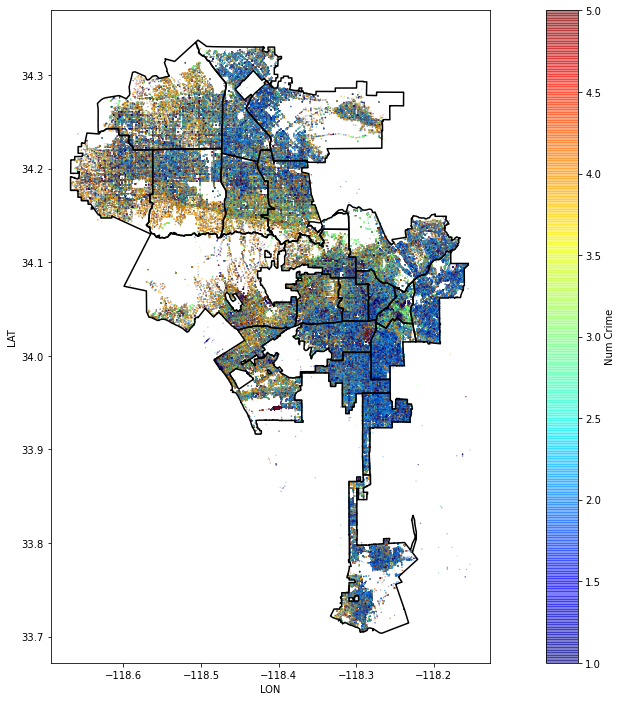

In [55]:
fig, ax = plt.subplots(1, figsize = (20, 12))
map_df.boundary.plot(color='black', ax=ax)
top_5_plot.plot(ax=ax, x='LON', y='LAT', kind='scatter', c='Num Crime',  s=0.1, alpha=0.5, cmap='jet')

We see from the plot that the most common crimes of Simple Assault/Battery and Stolen Vehicles appears to occur in the South East and Northern parts of Los Angeles, notably more inland than the other crimes. Burglary seems to occur towards the coast and outskirts of districts, towards the more Western side of the city. 

# Serious Crimes - include this in analysis

In [40]:
df_crime = pd.concat([past_df, present_df])

In [41]:
weapons = df_crime.drop(df_crime['Weapon Desc'].isna())

In [42]:
weapons['Weapon Desc'].value_counts()

STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)    559732
UNKNOWN WEAPON/OTHER WEAPON                        81916
VERBAL THREAT                                      76121
HAND GUN                                           48803
SEMI-AUTOMATIC PISTOL                              18378
                                                   ...  
ANTIQUE FIREARM                                       15
MAC-10 SEMIAUTOMATIC ASSAULT WEAPON                   13
MAC-11 SEMIAUTOMATIC ASSAULT WEAPON                   10
M1-1 SEMIAUTOMATIC ASSAULT RIFLE                       4
M-14 SEMIAUTOMATIC ASSAULT RIFLE                       2
Name: Weapon Desc, Length: 79, dtype: int64

In [43]:
weapons['Weapon Desc'].unique()

array([nan, 'HAND GUN', 'STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)',
       'UNKNOWN WEAPON/OTHER WEAPON', 'VERBAL THREAT', 'SIMULATED GUN',
       'FOLDING KNIFE', 'OTHER KNIFE', 'MACE/PEPPER SPRAY', 'STICK',
       'UNKNOWN FIREARM', 'SWITCH BLADE',
       'KNIFE WITH BLADE 6INCHES OR LESS', 'BOARD', 'BLUNT INSTRUMENT',
       'SEMI-AUTOMATIC PISTOL', 'VEHICLE', 'OTHER CUTTING INSTRUMENT',
       'SCISSORS', 'BOTTLE', 'KNIFE WITH BLADE OVER 6 INCHES IN LENGTH',
       'BELT FLAILING INSTRUMENT/CHAIN',
       'AUTOMATIC WEAPON/SUB-MACHINE GUN', 'CLUB/BAT', 'BRASS KNUCKLES',
       'KITCHEN KNIFE', 'AIR PISTOL/REVOLVER/RIFLE/BB GUN', 'SCREWDRIVER',
       'FIRE', 'STUN GUN', 'RIFLE', 'RAZOR BLADE', 'DIRK/DAGGER',
       'CAUSTIC CHEMICAL/POISON', 'SHOTGUN', 'ICE PICK', 'BOMB THREAT',
       'ROCK/THROWN OBJECT', 'REVOLVER', 'OTHER FIREARM', 'DEMAND NOTE',
       'BOWIE KNIFE', 'HECKLER & KOCH 93 SEMIAUTOMATIC ASSAULT RIFLE',
       'SCALDING LIQUID', 'ROPE/LIGATURE', 'MACHETE', 'T

In [44]:
severe = weapons[(weapons['Weapon Desc'].str.contains('RIFLE')) | 
        (weapons['Weapon Desc'].str.contains('PISTOL')) | 
       (weapons['Weapon Desc'].str.contains('ASSAULT RIFLE')) |
       (weapons['Weapon Desc'].str.contains('BOMB')) |
        (weapons['Weapon Desc'].str.contains('FIREARM')) |
        (weapons['Weapon Desc'].str.contains('SHOTGUN')) |
        (weapons['Weapon Desc'].str.contains('SEMIAUTOMATIC'))]

In [45]:
severe = severe.loc[(severe['LAT'] >= 33.7) & (severe['LAT'] <= 34.37) & (severe['LON'] >= -118.7) & (severe['LON'] <= -118.15)]

In [46]:
kmeans = KMeans(n_clusters=21)
kmeans.fit(severe[["LON", "LAT"]])

KMeans(n_clusters=21)

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

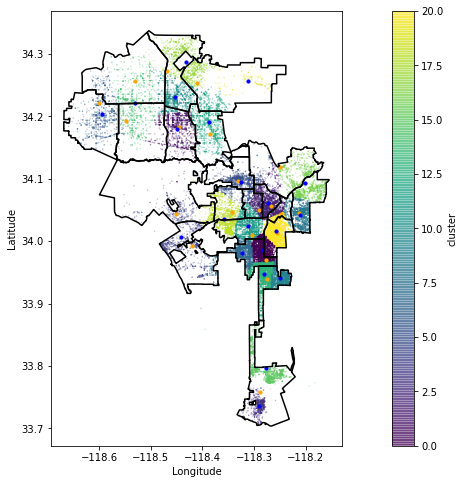

In [47]:
centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=['Longitude', 'Latitude'])

map_df = gpd.read_file('LAPD_Divisions.shp')

fig, ax = plt.subplots(1, figsize = (18, 8))
map_df.boundary.plot(color='black', ax=ax)


# labeling each crime to a cluster
severe["cluster"] = kmeans.predict(severe[["LON", "LAT"]])
severe.plot(ax=ax, x='LON', y='LAT', kind='scatter', c='cluster',  s=0.1, alpha=0.5, cmap='viridis')


LAPD_df.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', s=10, c='orange')
centers_df.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', s=10, c='blue') 

<AxesSubplot:>

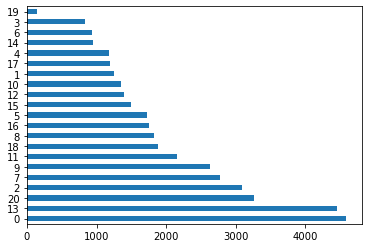

In [48]:
# Cluster Results
severe['cluster'].value_counts().plot(kind = 'barh')

<AxesSubplot:>

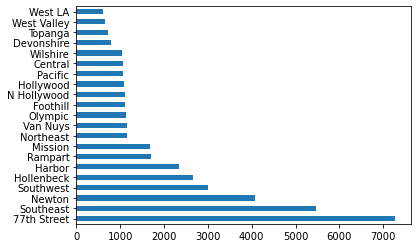

In [49]:
# Police Stations
severe['AREA NAME'].value_counts().plot(kind = 'barh')


# End of Analysis - Stop Here